ECE 8803 - Final Project

In [1]:
!pip install --user datasets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# load data
from datasets import load_dataset
ds = load_dataset("gOLIVES/OLIVES_Dataset", "biomarker_detection", cache_dir="./scratch/huggingface_datasets")

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/38 [00:00<?, ?it/s]

In [3]:
import numpy as np
from PIL import Image

# adjusing contrast of the image
def adjust_image(image, contrast_factor=1.2, brightness_offset=30):
    """
    Adjusts the image contrast and brightness.
    
    Parameters:
        image (PIL.Image.Image): Input image in grayscale
        contrast_factor (float): Multiplicative factor to enhance contrast.
        brightness_offset (float): Constant to add for brightness adjustment.
        
    Returns:
        np.ndarray: Adjusted image as a NumPy array with dtype uint8.
    """
    
    arr = np.array(image).astype(np.float32)
    
    # brightness offset and contrast factor manipulate array
    adjusted_arr = arr * contrast_factor + brightness_offset
    
    # stay in valid range
    adjusted_arr = np.clip(adjusted_arr, 0, 255)
    
    return adjusted_arr.astype(np.uint8)


In [4]:
import itertools
import pandas as pd
import numpy as np
from IPython.display import display

train_samples = ds["train"]
df = pd.DataFrame(train_samples)

# drop empty rows
df_clean = df.dropna(subset=["B1", "B2", "B3", "B4", "B5", "B6"])

# get X and y
X = df_clean["Image"]
y = df_clean[["B1", "B2", "B3", "B4", "B5", "B6"]]

# apply image pre-processing
X = X.apply(lambda img: adjust_image(img, contrast_factor=1.2, brightness_offset=20))

print("Cleaned Feature (X) sample (as NumPy arrays):")
print(X.head())

print("\nCleaned Target (y) sample:")
print(y.head())

print("Minimum value in y:", y.values.min())
print("Maximum value in y:", y.values.max())

print(len(X))
print(len(y))

# 6468 at 30000
# 8428 at 40000
# 11613 at 50000
# 17591 at 80000

Cleaned Feature (X) sample (as NumPy arrays):
0    [[20, 39, 29, 20, 23, 22, 27, 36, 28, 20, 20, ...
1    [[20, 39, 29, 20, 23, 22, 27, 36, 28, 20, 20, ...
2    [[24, 21, 21, 34, 48, 24, 20, 20, 28, 51, 33, ...
3    [[24, 21, 21, 34, 48, 24, 20, 20, 28, 51, 33, ...
4    [[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, ...
Name: Image, dtype: object

Cleaned Target (y) sample:
    B1   B2   B3   B4   B5   B6
0  1.0  0.0  1.0  1.0  0.0  1.0
1  1.0  0.0  1.0  1.0  0.0  1.0
2  1.0  0.0  1.0  1.0  0.0  0.0
3  1.0  0.0  1.0  1.0  0.0  0.0
4  1.0  0.0  1.0  0.0  0.0  0.0
Minimum value in y: 0.0
Maximum value in y: 1.0
17591
17591


In [5]:
import itertools
import pandas as pd
import numpy as np
from IPython.display import display

test_samples = ds["test"]
df_test = pd.DataFrame(test_samples)

# drop rows
df_test_clean = df_test.dropna(subset=["B1", "B2", "B3", "B4", "B5", "B6"])

# extract X and y
X_test = df_test_clean["Image"]
y_test = df_test_clean[["B1", "B2", "B3", "B4", "B5", "B6"]]

# image preprocessing
X_test = X_test.apply(lambda img: adjust_image(img, contrast_factor=1.2, brightness_offset=20))

print("Test Feature (X_test) sample (as NumPy arrays):")
print(X_test.head())

print("\nTest Target (y_test) sample:")
print(y_test.head())

print("\nRange of test targets:")
print("Minimum value in y:", y_test.values.min())
print("Maximum value in y:", y_test.values.max())


Test Feature (X_test) sample (as NumPy arrays):
0    [[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, ...
1    [[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, ...
2    [[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, ...
3    [[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, ...
4    [[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, ...
Name: Image, dtype: object

Test Target (y_test) sample:
    B1   B2   B3   B4   B5   B6
0  0.0  0.0  1.0  1.0  0.0  0.0
1  0.0  0.0  1.0  0.0  0.0  0.0
2  0.0  0.0  1.0  0.0  0.0  0.0
3  0.0  0.0  1.0  0.0  0.0  0.0
4  0.0  0.0  1.0  0.0  0.0  0.0

Range of test targets:
Minimum value in y: 0.0
Maximum value in y: 1.0


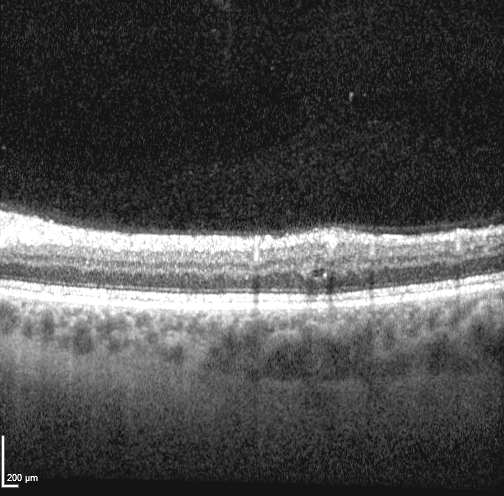

In [6]:
# image display example
display(Image.fromarray(X[0]))


In [6]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# ----------------------------------#
# 1‑channel (grayscale) transform
maxvit_transform = transforms.Compose([
    # get array to tensor
    transforms.ToTensor(),
    # normalize with data calculated mean and std
    transforms.Normalize(
        mean=[0.27961495518684387],
        std=[0.252422571182251],
    ),
])

class BiomarkerDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = self.X.iloc[idx]
        
        # convert to grayscale single array size
        img = Image.fromarray(img.astype(np.uint8)).convert("L")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.y.iloc[idx].astype(np.float32))
        return img, label

# ----------------------------------#
# from previous homeworks

train_batch_size = 32
test_batch_size  = 1

train_dataset = BiomarkerDataset(X, y, transform=maxvit_transform)
trainloader  = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

test_dataset  = BiomarkerDataset(X_test, y_test, transform=maxvit_transform)
testloader   = DataLoader(test_dataset,  batch_size=test_batch_size, shuffle=False)

for inputs, targets in trainloader:
    print("Batch of inputs has shape:", inputs.shape)  # now (batch_size, 1, H, W)
    print("Batch of targets has shape:", targets.shape)# (batch_size, num_targets)
    break


Batch of inputs has shape: torch.Size([32, 1, 496, 504])
Batch of targets has shape: torch.Size([32, 6])


In [11]:
import torch
import torch.nn as nn

class BiomarkerCNN(nn.Module):
    def __init__(self):
        super(BiomarkerCNN, self).__init__()
        
        # first convolutional block:
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        # second convolutional block:
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # third convolutional block:
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # adaptive average pooling to force feature map to shape (batch, 64, 1, 1)
        self.adaptpool = nn.AdaptiveAvgPool2d((1, 1))

        # fully connected layer
        self.fc = nn.Linear(64, 6)
        
        # sigmoid on output
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input x assumed to be of shape (batch_size, 1, 504, 496)
        x = torch.relu(self.conv1(x))
        x = self.pool(x)

        x = torch.relu(self.conv2(x))
        x = self.pool(x)

        x = torch.relu(self.conv3(x))
        x = self.pool(x)

        x = self.adaptpool(x)  # Result shape: (batch_size, 64, 1, 1)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 64)

        x = self.fc(x)   # (batch_size, 6)
        x = self.sigmoid(x)

        return x

In [13]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# training hyperparameters
lr = 1e-3
epochs = 20

# initalize net
net = BiomarkerCNN().to(device)

# use BCELoss as loss function and Adam optimizer
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

for epoch in range(epochs):
    net.train()
    for iteration, (x, y) in enumerate(trainloader):
        x = x.to(device)
        y_i = y.to(device)
        optimizer.zero_grad()
        y_i = y_i.float()
        
        # forward pass
        out = net(x)
        
        # loss compute
        loss = loss_function(out, y_i)
        
        # backprop
        loss.backward()
        optimizer.step()
        
        print(f'Epoch: {epoch} | Iteration: {iteration} | Training Loss: {loss.item():.4f}')
        
# 0.3313 loss to beat

Using device: cuda
Epoch: 0 | Iteration: 0 | Training Loss: 0.6989
Epoch: 0 | Iteration: 1 | Training Loss: 0.6978
Epoch: 0 | Iteration: 2 | Training Loss: 0.6910
Epoch: 0 | Iteration: 3 | Training Loss: 0.6877
Epoch: 0 | Iteration: 4 | Training Loss: 0.6817
Epoch: 0 | Iteration: 5 | Training Loss: 0.6839
Epoch: 0 | Iteration: 6 | Training Loss: 0.6732
Epoch: 0 | Iteration: 7 | Training Loss: 0.6671
Epoch: 0 | Iteration: 8 | Training Loss: 0.6510
Epoch: 0 | Iteration: 9 | Training Loss: 0.6652
Epoch: 0 | Iteration: 10 | Training Loss: 0.6548
Epoch: 0 | Iteration: 11 | Training Loss: 0.6656
Epoch: 0 | Iteration: 12 | Training Loss: 0.6633
Epoch: 0 | Iteration: 13 | Training Loss: 0.6303
Epoch: 0 | Iteration: 14 | Training Loss: 0.6210
Epoch: 0 | Iteration: 15 | Training Loss: 0.6886
Epoch: 0 | Iteration: 16 | Training Loss: 0.6528
Epoch: 0 | Iteration: 17 | Training Loss: 0.6394
Epoch: 0 | Iteration: 18 | Training Loss: 0.6451
Epoch: 0 | Iteration: 19 | Training Loss: 0.6745
Epoch: 0 | 

In [16]:
import torch

net.eval()

# accumalators
TP = 0
FP = 0
FN = 0

with torch.no_grad():
    for x, y in testloader:
        x, y = x.to(device), y.to(device)
        
        # forward pass.
        outputs = net(x)
        print(outputs)
        
        # Threshold probabilities to get binary predictions.
        predictions = (outputs >= 0.5).float()
        
        # Update counts.
        # True Positive: both prediction and target are 1.
        TP += ((predictions == 1) & (y == 1)).sum().item()
        # False Positive: prediction is 1 while target is 0.
        FP += ((predictions == 1) & (y == 0)).sum().item()
        # False Negative: prediction is 0 while target is 1.
        FN += ((predictions == 0) & (y == 1)).sum().item()

# Avoid division by zero.
epsilon = 1e-8
f1_score = TP / (TP + 0.5 * (FP + FN) + epsilon)

print("F1 Score on test set: {:.4f}".format(f1_score))

# F1 to beat 0.5663

tensor([[0.7157, 0.0826, 0.9260, 0.7030, 0.0160, 0.0867]], device='cuda:0')
tensor([[0.8740, 0.1645, 0.8089, 0.7501, 0.0368, 0.1563]], device='cuda:0')
tensor([[0.8455, 0.1220, 0.8364, 0.7395, 0.0211, 0.1130]], device='cuda:0')
tensor([[0.8580, 0.2127, 0.6816, 0.6347, 0.0484, 0.1838]], device='cuda:0')
tensor([[0.6089, 0.1750, 0.7444, 0.6380, 0.0103, 0.0519]], device='cuda:0')
tensor([[0.5971, 0.3454, 0.6053, 0.5149, 0.0353, 0.1152]], device='cuda:0')
tensor([[0.6172, 0.1707, 0.7566, 0.6911, 0.0246, 0.1002]], device='cuda:0')
tensor([[0.5244, 0.1977, 0.7153, 0.6974, 0.0246, 0.0877]], device='cuda:0')
tensor([[0.8019, 0.1052, 0.8616, 0.6655, 0.0409, 0.1882]], device='cuda:0')
tensor([[0.3746, 0.1303, 0.8215, 0.6829, 0.0126, 0.0536]], device='cuda:0')
tensor([[0.4925, 0.1473, 0.7275, 0.6268, 0.0248, 0.0844]], device='cuda:0')
tensor([[0.6312, 0.1218, 0.7083, 0.5431, 0.0347, 0.1381]], device='cuda:0')
tensor([[0.4239, 0.1255, 0.7572, 0.5247, 0.0187, 0.0792]], device='cuda:0')
tensor([[0.6